## Grouping Galaxies based on Spatial Coordinates & Properties using Agglomerative Hierarchial Clustering

In [ ]:
!pip install astroquery astropy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 49.4 MB/s eta 0:00:00


In [ ]:
from astroquery.sdss import SDSS
from astropy.table import Table
import pandas as pd

# Define the SQL query to select galaxies with specific criteria
query = """
SELECT TOP 1000
  p.objid, p.ra, p.dec, s.z AS redshift,
  p.u, p.g, p.r, p.i, p.z
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE s.class = 'GALAXY' AND s.z BETWEEN 0.01 AND 0.3
"""

# Execute the query
results = SDSS.query_sql(query)

# Convert the results to a pandas DataFrame
df = results.to_pandas()

# Display the first few rows
print(df.head())

                 objid          ra       dec  redshift         u         g  \
0  1237648704046760145  198.367594 -0.356065  0.211824  20.73523  18.85085   
1  1237648704046760198  198.428206 -0.384406  0.094445  18.44623  17.23412   
2  1237648704046825622  198.462136 -0.219281  0.121077  19.30241  17.78075   
3  1237648704046825624  198.466124 -0.254391  0.138055  20.16626  18.28559   
4  1237648704046825654  198.493224 -0.256808  0.138718  19.09543  17.31310   

          r         i         z  
0  17.56961  17.08212  16.70905  
1  16.67523  16.29652  16.07245  
2  16.90307  16.49114  16.18247  
3  17.22367  16.79652  16.40390  
4  16.35899  15.97224  15.63603  


In [ ]:
df.head()

,objid,ra,dec,redshift,u,g,r,i,z
0,1237648704046760145,198.367594,-0.356065,0.211824,20.73523,18.85085,17.56961,17.08212,16.70905
1,1237648704046760198,198.428206,-0.384406,0.094445,18.44623,17.23412,16.67523,16.29652,16.07245
2,1237648704046825622,198.462136,-0.219281,0.121077,19.30241,17.78075,16.90307,16.49114,16.18247
3,1237648704046825624,198.466124,-0.254391,0.138055,20.16626,18.28559,17.22367,16.79652,16.40390
4,1237648704046825654,198.493224,-0.256808,0.138718,19.09543,17.31310,16.35899,15.97224,15.63603


In [ ]:
from sklearn.preprocessing import StandardScaler

# Compute color indices
df['u_g'] = df['u'] - df['g']
df['g_r'] = df['g'] - df['r']

# Select features for clustering
features = ['ra', 'dec', 'redshift', 'u_g', 'g_r']
X = df[features].dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the clustering model
n_clusters = 4  # Adjust as needed
clustering = AgglomerativeClustering(n_clusters=n_clusters)
labels = clustering.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
df['cluster'] = labels

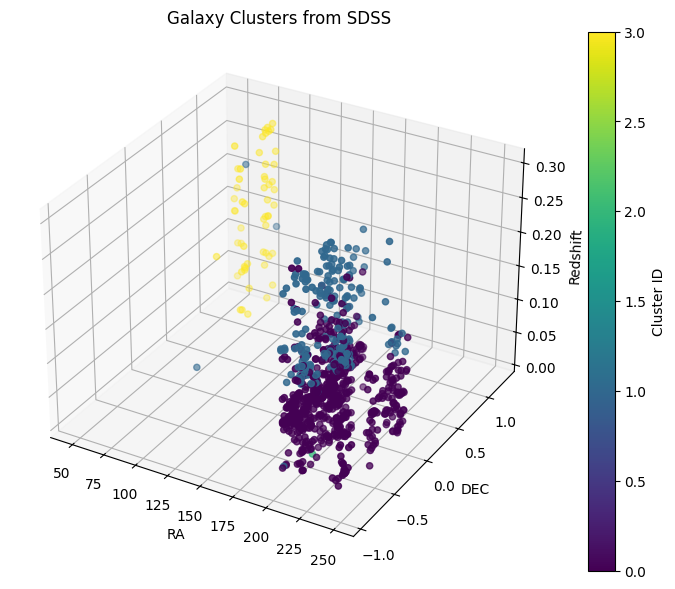

In [ ]:
# Visualize the clusters in 3D space
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['ra'], df['dec'], df['redshift'], c=labels, cmap='viridis', s=20)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_zlabel('Redshift')
plt.title('Galaxy Clusters from SDSS')
plt.colorbar(scatter, label='Cluster ID')
plt.show()

In [ ]:
# silhouette score
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, df['cluster'])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.307


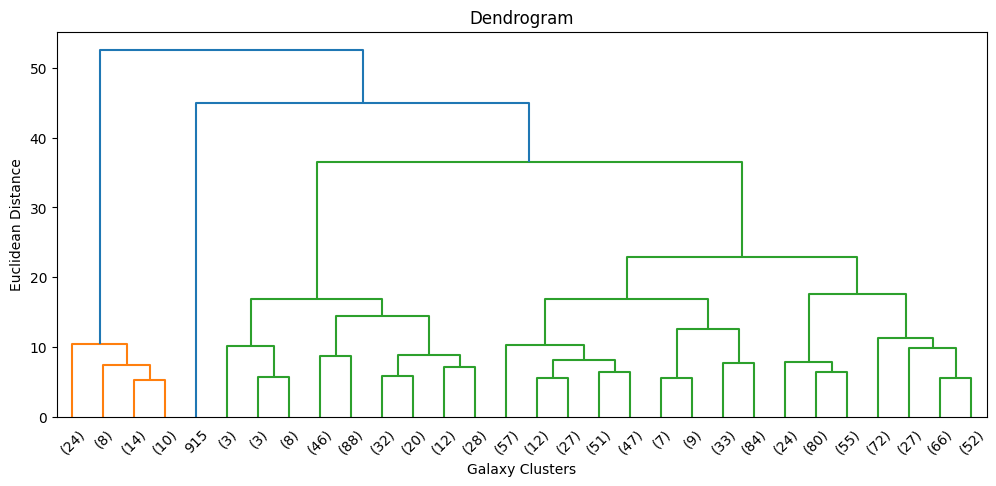

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(linked, distance_sort='ascending', truncate_mode='lastp', p=30)
plt.title("Dendrogram")
plt.xlabel("Galaxy Clusters")
plt.ylabel("Euclidean Distance")
plt.show()

2D Projections for presentation

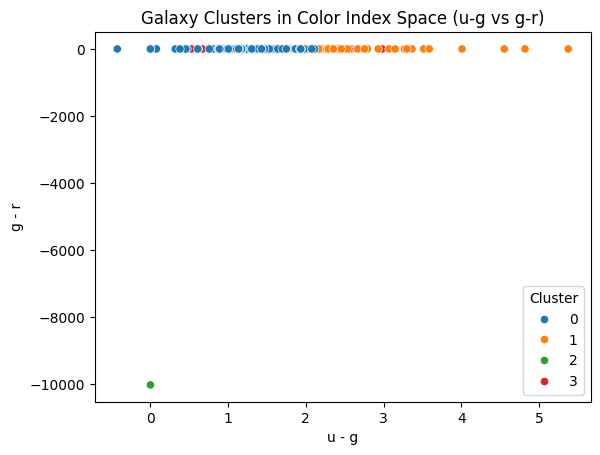

In [ ]:
import seaborn as sns

sns.scatterplot(data=df, x='u_g', y='g_r', hue='cluster', palette='tab10')
plt.title("Galaxy Clusters in Color Index Space (u-g vs g-r)")
plt.xlabel("u - g")
plt.ylabel("g - r")
plt.legend(title="Cluster")
plt.show()

In [ ]:
df.to_csv("clustered_galaxies_sdss.csv", index=False)

🔍 1. Do some clusters have higher redshift → distant galaxies?

<ipython-input-11-b8ab9308fd25>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='redshift', data=df, palette='viridis')


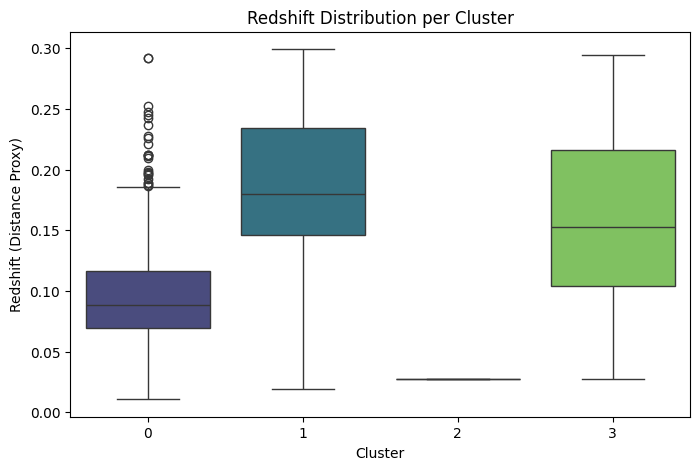

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of redshift per cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x='cluster', y='redshift', data=df, palette='viridis')
plt.title("Redshift Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Redshift (Distance Proxy)")
plt.show()

🎨 2. Do color indices (u–g, g–r) reflect galaxy types?

Background:

Blue galaxies (low u-g/g-r) → younger, star-forming (spirals).

Red galaxies (high u-g/g-r) → older, passive (ellipticals).

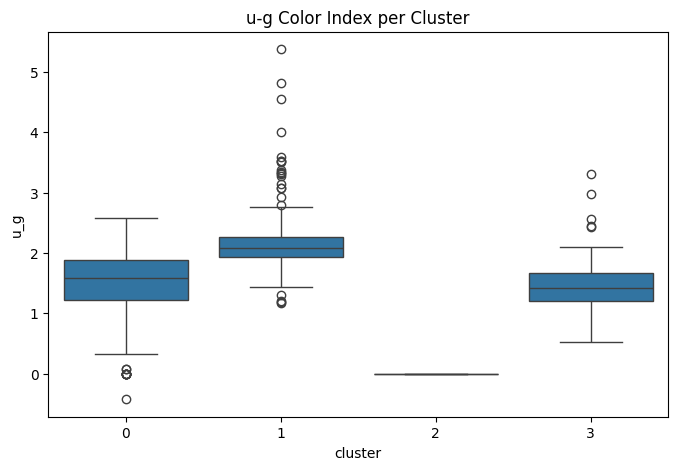

In [ ]:
# u-g and g-r distributions across clusters
plt.figure(figsize=(8, 5))
sns.boxplot(x='cluster', y='u_g', data=df)
plt.title("u-g Color Index per Cluster")
plt.show()

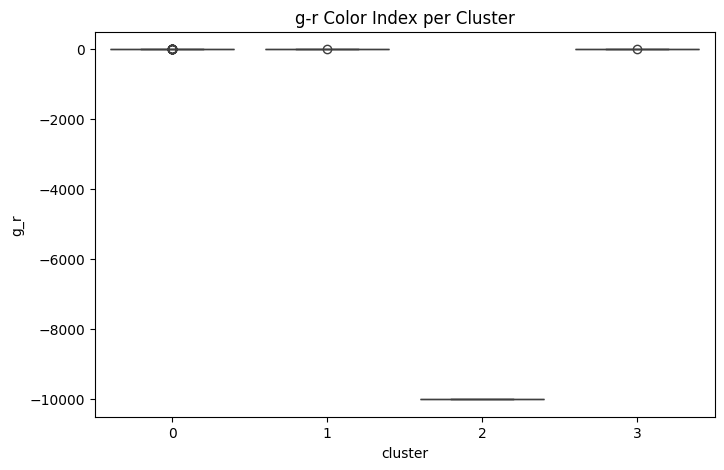

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='cluster', y='g_r', data=df)
plt.title("g-r Color Index per Cluster")
plt.show()

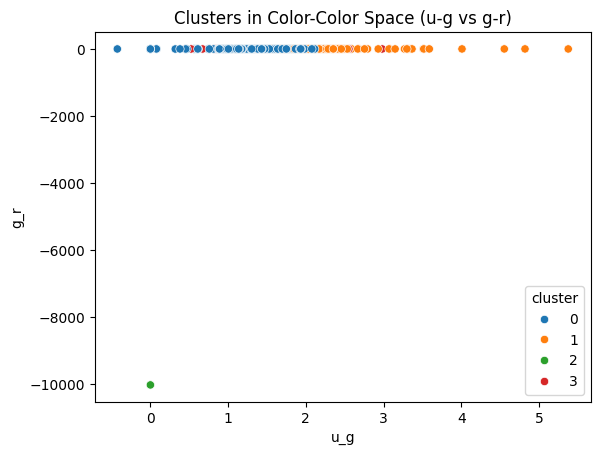

In [ ]:
sns.scatterplot(data=df, x='u_g', y='g_r', hue='cluster', palette='tab10')
plt.title("Clusters in Color-Color Space (u-g vs g-r)")
plt.show()

🌌 3. Any spatial concentration in RA/DEC?

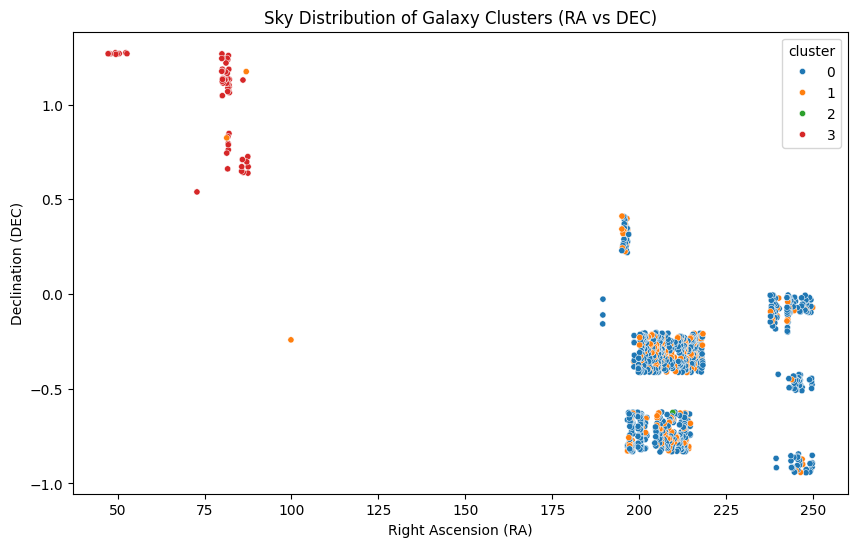

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ra', y='dec', hue='cluster', palette='tab10', s=20)
plt.title("Sky Distribution of Galaxy Clusters (RA vs DEC)")
plt.xlabel("Right Ascension (RA)")
plt.ylabel("Declination (DEC)")
plt.show()

🔎 Interpretation:\
Clusters forming dense groups in RA/DEC suggest physical proximity (e.g., real galaxy groups).

If the clustering is randomly scattered, your clustering might be driven more by redshift or color than spatial location.